# Using a Framework

## Imports

In [1]:
from pathlib import Path
import os

# titanic dataset installed, not kaggle:
path = Path("titanic")


In [2]:
from fastai.tabular.all import *
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Read in and Process the Data

In [3]:
df = pd.read_csv(path/"train.csv")

In [4]:
def add_features(df):
    df["LogFare"] = np.log1p(df["Fare"])
    df["Deck"] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df["Family"] = df.SibSp + df.Parch
    df["Alone"] = df["Family"] == 1
    
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')

    # name title
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

In [5]:
splits = RandomSplitter(seed=42)(df)

## Build the Model

In [7]:
dls = TabularPandas(
    df, splits=splits,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names=["Age", "SibSp", "Parch", "LogFare", "Alone", "TicketFreq", "Family"],
    y_names="Survived", y_block=CategoryBlock(),
).dataloaders(path=".")

/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [8]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])

SuggestedLRs(slide=0.0831763744354248, valley=0.007585775572806597)

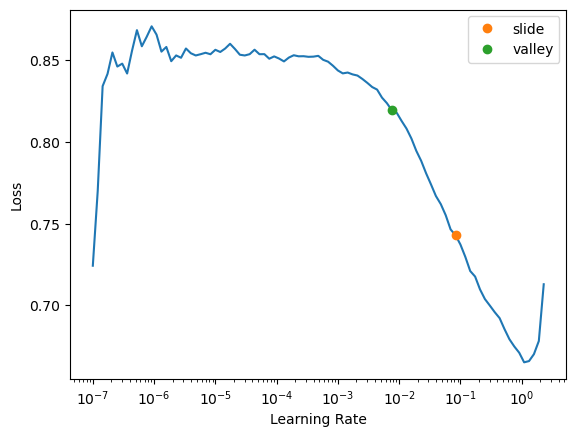

In [9]:
learn.lr_find(suggest_funcs=(slide, valley))

## Training the Model

In [10]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.613584,0.569368,0.657303,00:00
1,0.528174,0.416915,0.808989,00:00
2,0.484392,0.411919,0.808989,00:00
3,0.458103,0.425840,0.820225,00:00
4,0.448874,0.425477,0.831461,00:00
5,0.437680,0.425037,0.820225,00:00
6,0.427227,0.417674,0.803371,00:00
7,0.420390,0.400852,0.825843,00:00
8,0.416741,0.411089,0.825843,00:00
9,0.413803,0.433529,0.831461,00:00


In [11]:
test_df = pd.read_csv(path/"test.csv")
test_df["Fare"] = test_df["Fare"].fillna(0)
add_features(test_df)

In [12]:
test_dl = learn.dls.test_dl(test_df)

/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [13]:
preds, _ = learn.get_preds(dl=test_dl)

test_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = test_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [14]:
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Ensembling

In [15]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(), learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=test_dl)[0]

In [16]:
learns = [ensemble() for _ in range(5)]

In [17]:
ens_preds = torch.stack(learns).mean(0)

In [18]:
test_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = test_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

!head ens_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
